94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 41s 0us/step
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4806 - loss: 0.7117 - val_accuracy: 0.5000 - val_loss: 0.6861
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5618 - loss: 0.6623 - val_accuracy: 0.5556 - val_loss: 0.6622
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6074 - loss: 0.6548 - val_accuracy: 0.6667 - val_loss: 0.6277
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6592 - loss: 0.6307 - val_accuracy: 0.7778 - val_loss: 0.6140
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7357 - loss: 0.6116 - val_accuracy: 0.7778 - val_loss: 0.6035
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7295 - loss: 0.5854 - val_accuracy: 0.7222 - val_loss: 0.6034
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 953ms/step - accuracy: 0.7226 - loss: 0.5645 - val_accuracy: 0.7407 - val_loss: 0.5938
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 744ms/step - accuracy: 0.7448 - loss: 0.567

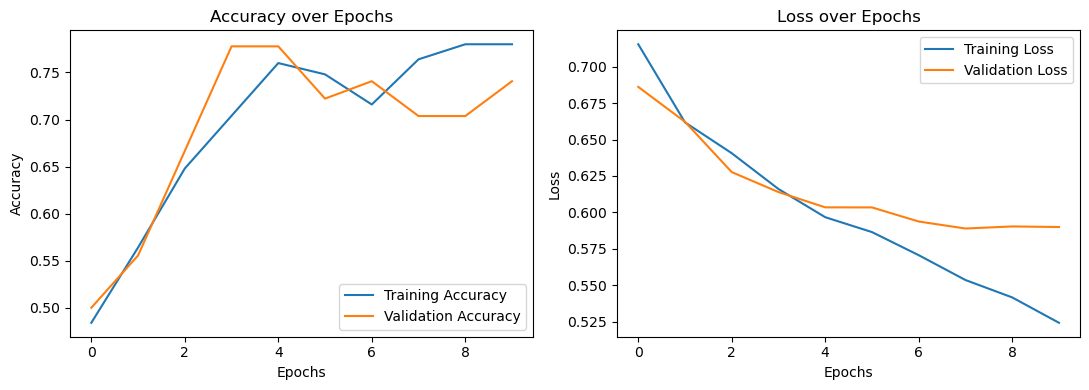

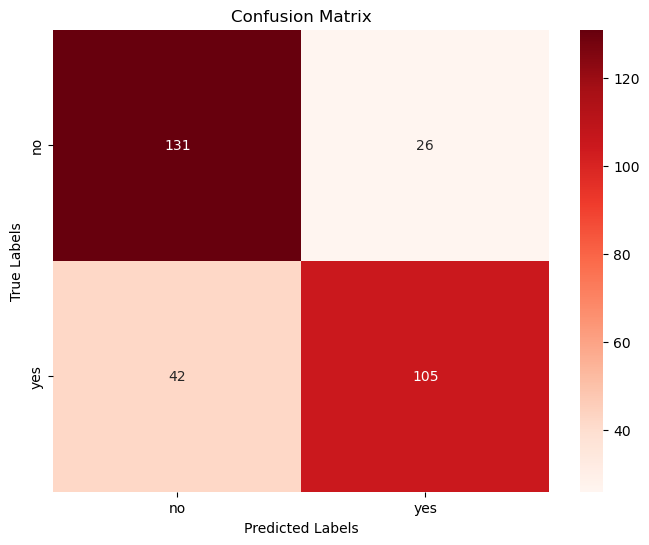

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step


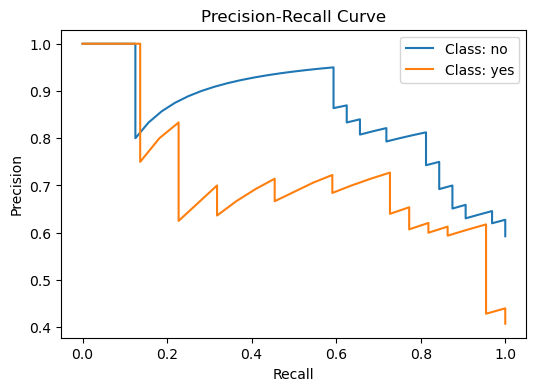

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step


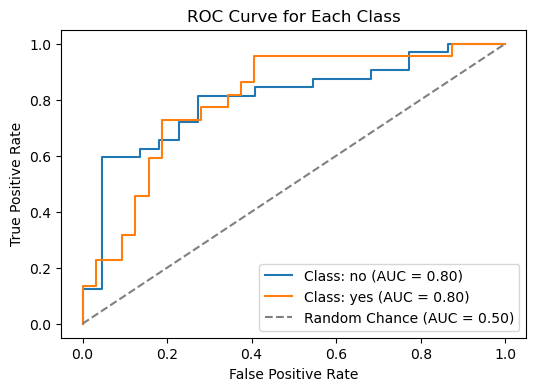

In [8]:
#resnet50

import zipfile
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.utils import to_categorical

# Step 1: Extract the uploaded ZIP file
data_dir = "C:\\Users\\princ\\Downloads\\dataset1"
zip_file = 'dataset1.zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Step 2: Load and preprocess the data
def load_data(data_path):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(root, file)
                label = os.path.basename(root)

                # Load and preprocess the image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(label)

    images = np.array(images) / 255.0  # Normalize images
    labels = np.array(labels)

    return images, labels

# Load the dataset
images, labels = load_data(data_dir)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Define the ResNet50 model
def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model initially

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

input_shape = (128, 128, 3)
num_classes = labels_categorical.shape[1]
model = build_resnet50_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Step 5: Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Predict for training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predictions and true labels back to categorical
y_train_true = np.argmax(y_train, axis=1)
y_train_pred = np.argmax(y_train_pred, axis=1)

y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)

# Step 6: Metrics per class
def print_class_metrics(true_labels, pred_labels, class_names):
    print("\nMetrics by Class:")
    for i, class_name in enumerate(class_names):
        class_true = (true_labels == i).astype(int)
        class_pred = (pred_labels == i).astype(int)
        
        precision = precision_score(class_true, class_pred)
        recall = recall_score(class_true, class_pred)
        f1 = f1_score(class_true, class_pred)
        cohen_kappa = cohen_kappa_score(class_true, class_pred)
        roc_auc = roc_auc_score(class_true, class_pred)
        accuracy = np.mean(class_true == class_pred)

        print(f"\nClass: {class_name}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(f"Cohen Kappa: {cohen_kappa:.2f}")
        print(f"ROC AUC: {roc_auc:.2f}")

# Print metrics for training data
print("Training Metrics:")
print_class_metrics(y_train_true, y_train_pred, label_encoder.classes_)

# Print metrics for testing data
print("\nTesting Metrics:")
print_class_metrics(y_test_true, y_test_pred, label_encoder.classes_)

# Print overall results
print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")


# Step 7: Plot training and validation accuracy and loss
plt.figure(figsize=(11, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 9: Overall confusion matrix (combined training and testing data)
y_combined_true = np.concatenate((y_train_true, y_test_true))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))
overall_cm = confusion_matrix(y_combined_true, y_combined_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 10: Precision-Recall Curve for each class
def plot_precision_recall(true_labels, pred_probs, class_names):
    plt.figure(figsize=(6, 4))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(true_labels[:, i], pred_probs[:, i])
        plt.plot(recall, precision, label=f'Class: {class_name}')

    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Plot Precision-Recall curves for testing data
plot_precision_recall(y_test, model.predict(X_test), label_encoder.classes_)

# Step 11: Plot ROC Curve for each class
def plot_roc_curve(true_labels, pred_probs, class_names):
    plt.figure(figsize=(6, 4))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels[:, i], pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class: {class_name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line for random chance
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance (AUC = 0.50)')
    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Get prediction probabilities for the test set
y_test_probs = model.predict(X_test)

# Plot ROC curves for each class
plot_roc_curve(y_test, y_test_probs, label_encoder.classes_)
